In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from pycytominer import feature_select, normalize
from sklearn.decomposition import PCA

/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_path = pathlib.Path("../../data/5.converted_data/output.parquet").resolve(
    strict=True
)

df = pd.read_parquet(df_path)

In [3]:
df["Metadata_genotype"] = df["Metadata_Image_FileName_OP"].str.split("_").str[1]
df["Metadata_replicate"] = df["Metadata_Image_FileName_OP"].str.split("_").str[2]
df["Metadata_side"] = (
    df["Metadata_Image_FileName_OP"].str.split("_").str[3].str.split(".tiff").str[0]
)
df["Metadata_genotype"].value_counts()

Metadata_genotype
wt       56
unsel    52
high     28
Name: count, dtype: int64

In [5]:
# split the data into metadata and features by columns that contain metadata
metadata = df.columns[df.columns.str.contains("Metadata")]
metadata_df = df[metadata]
features_df = df.drop(metadata, axis=1)

print(df.shape, metadata_df.shape, features_df.shape)

(136, 127) (136, 18) (136, 109)


In [6]:
feature_list = features_df.columns.to_list()
metadata_list = metadata_df.columns.to_list()
# use pycytominer to normalize the data

df = normalize(
    profiles=df,
    features=feature_list,
    meta_features=metadata_list,
)
# write the normalized data to a parquet file
df.to_parquet("../../data/5.converted_data/normalized_output.parquet")
print(df.shape, metadata_df.shape, features_df.shape)

df = feature_select(
    profiles=df,
    features=feature_list,
    operation="variance_threshold",
)
print(df.shape, metadata_df.shape, features_df.shape)
# write the normalized and feature selected data to a parquet file
df.to_parquet("../../data/5.converted_data/normalized_feature_selected_output.parquet")

(136, 127) (136, 18) (136, 109)
(136, 120) (136, 18) (136, 109)


/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [7]:
# split the data into metadata and features by columns that contain metadata
metadata = df.columns[df.columns.str.contains("Metadata")]
metadata_df = df[metadata]
features_df = df.drop(metadata, axis=1)

print(df.shape, metadata_df.shape, features_df.shape)

(136, 120) (136, 18) (136, 102)


## Get a look at the data 
Confirm counts across groups - look at latent spaces etc

/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


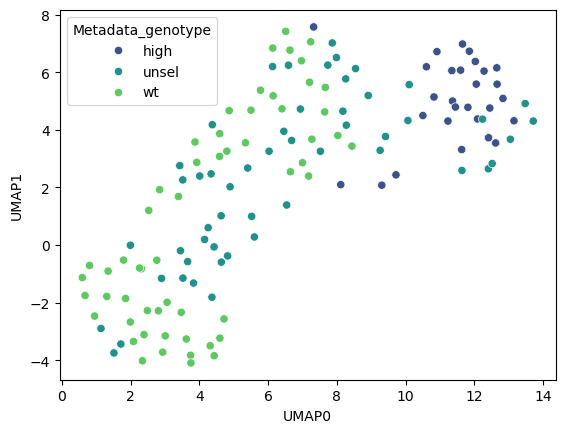

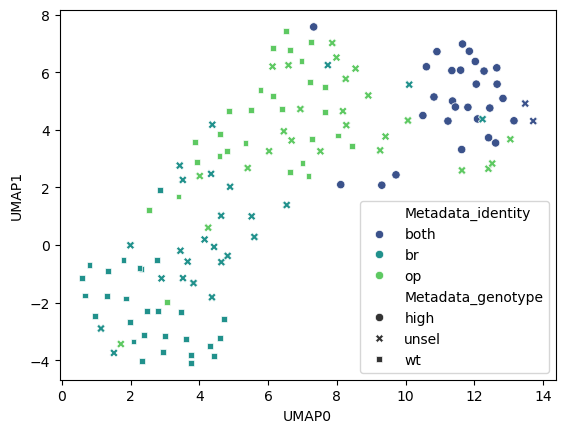

In [8]:
# generate a umap of the features

reducer = umap.UMAP(
    n_neighbors=7,
    min_dist=0.7,
    n_components=2,
    metric="cosine",
    random_state=0,
)

embedding = reducer.fit_transform(features_df)

embedding_df = pd.DataFrame(embedding, columns=["UMAP0", "UMAP1"])
embedding_df["Metadata_genotype"] = metadata_df["Metadata_genotype"]
embedding_df["Metadata_identity"] = metadata_df["Metadata_identity"]

# plot
sns.scatterplot(
    data=embedding_df, x="UMAP0", y="UMAP1", hue="Metadata_genotype", palette="viridis"
)
plt.show()
plt.close()

# plot the umap with identity
sns.scatterplot(
    data=embedding_df,
    x="UMAP0",
    y="UMAP1",
    hue="Metadata_identity",
    style="Metadata_genotype",
    palette="viridis",
)
plt.show()
plt.close()

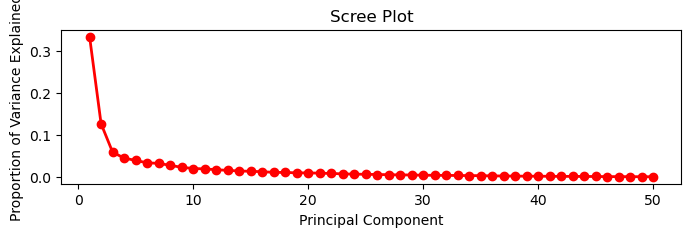

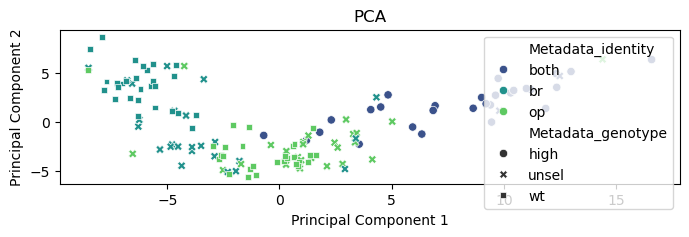

In [9]:
# Perform PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(features_df)
# Calculate percentage of variance explained by each of the selected components
explained_variance_ratio = pca.explained_variance_ratio_

# Create an array with the number of components
n_components = range(1, len(explained_variance_ratio) + 1)
X_pca_df = pd.DataFrame(X_pca, columns=[f"PCA{i}" for i in range(1, 51)])
X_pca_df["Metadata_genotype"] = metadata_df["Metadata_genotype"]
X_pca_df["Metadata_identity"] = metadata_df["Metadata_identity"]

# Create a scree plot
plt.figure(figsize=(8, 2))
plt.plot(n_components, explained_variance_ratio, "ro-", linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.show()


# plot the first two principal components
plt.figure(figsize=(8, 2))
# make the dots colored by genotype
sns.scatterplot(
    data=X_pca_df,
    x="PCA1",
    y="PCA2",
    hue="Metadata_identity",
    style="Metadata_genotype",
    palette="viridis",
)
plt.title("PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

/tmp/ipykernel_454256/592948066.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x="Metadata_identity", palette="viridis")


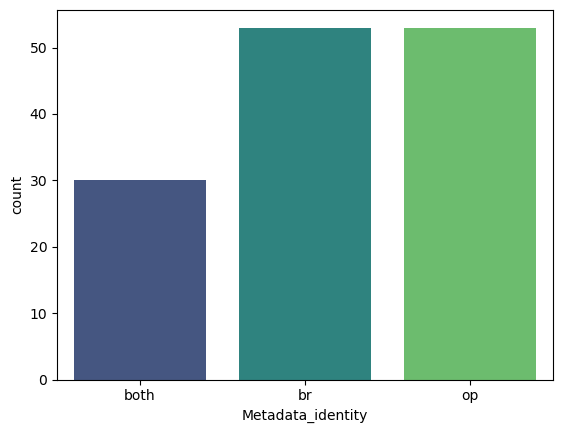

In [10]:
# plot the number of objects per genotype
sns.countplot(data=metadata_df, x="Metadata_identity", palette="viridis")
plt.show()

/tmp/ipykernel_454256/3762035010.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x="Metadata_genotype", palette="viridis")


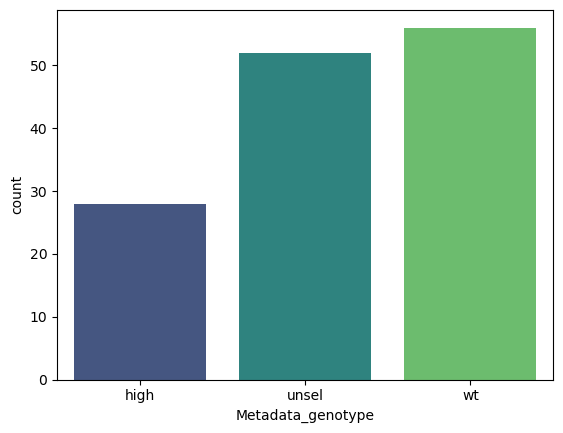

In [11]:
# plot the number of objects per genotype
sns.countplot(data=metadata_df, x="Metadata_genotype", palette="viridis")
plt.show()

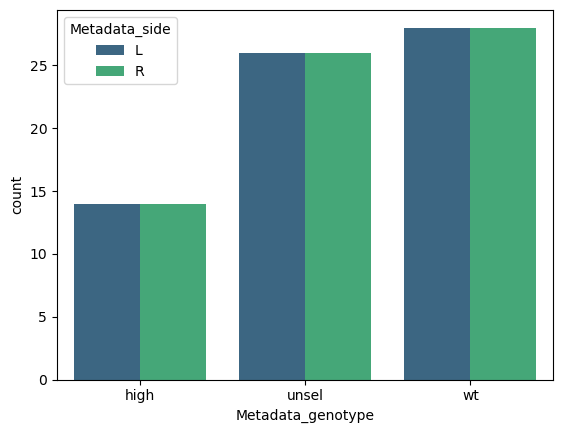

In [12]:
# plot the number of objects per genotype and side
sns.countplot(
    data=metadata_df, x="Metadata_genotype", hue="Metadata_side", palette="viridis"
)
plt.show()

/tmp/ipykernel_454256/2931792134.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Metadata_genotype", y="AreaShape_FormFactor", palette="viridis")


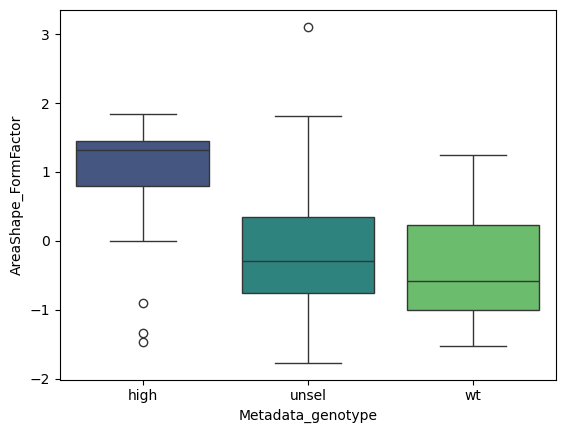

In [13]:
# plot the AreaShape_FormFactor features for df genotypes
sns.boxplot(data=df, x="Metadata_genotype", y="AreaShape_FormFactor", palette="viridis")
plt.show()